#  Elo Competition
## This kernel cotains four parts:
### 1. Loading the data
### 2. Feature engineering -- extract key info from transaction records
### 3. Feature importance -- evaluate features' importance and select key features for training model.
### 4. Traning LGB model

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [2]:
# Reduce the memory usage for dataframe
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## 1. Loading the data

In [3]:
path = os.getcwd()

In [4]:
new_transactions = pd.read_csv(path+'/new_merchant_transactions.csv',parse_dates=['purchase_date'])
historical_transactions = pd.read_csv(path+'/historical_transactions.csv',parse_dates=['purchase_date'])

In [5]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [6]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


#### The authorized_flag and category_1 only have two values: 'Y' and 'N'. So map them into binary format     

In [7]:
for col in ['authorized_flag','category_1']:
    new_transactions[col] = new_transactions[col].map({'Y':1, 'N':0})
    historical_transactions[col] = historical_transactions[col].map({'Y':1, 'N':0})

In [8]:
train = pd.read_csv(path + '/train.csv')
test = pd.read_csv(path + '/test.csv')

In [9]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [10]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


#### change first_active_month to pd.datatime format

In [11]:
train['first_active_month'] = pd.to_datetime(train['first_active_month'])
test['first_active_month'] = pd.to_datetime(test['first_active_month'])
target = train['target']
del train['target']

# 2. Feature Engineering
## 2.1 One-hot encoding for categorical features

In [12]:
new_transactions['category_2'].unique()

array([ 1., nan,  3.,  2.,  4.,  5.])

In [13]:
new_transactions['category_3'].unique()

array(['B', nan, 'C', 'A'], dtype=object)

In [14]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

## 2.2 Adding new features

In [15]:
historical_transactions['month_to_now'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30 +  \
                                            historical_transactions['month_lag']
new_transactions['month_to_now'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30 +  \
                                            new_transactions['month_lag']

In [16]:
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


## 2.3 Aggregating the info by grouping on card_id

In [17]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).astype(np.int64) * 1e-9
    
    agg_func = {
    'authorized_flag': ['sum', 'mean'],
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_to_now': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [18]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]

In [19]:
history.head()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_to_now_mean
0,C_ID_00007093c1,149,114.0,0.765101,28.0,0.187919,0.000000,0.000000,0.805369,0.0,0.006711,0.000000,0.838926,0.161074,29,18,3,4,13,-76.845039,-0.515739,1.507069,-0.728876,0.298141,192,1.288591,6,1,0.764900,32627654.0,1.487081e+09,1.519708e+09,-5.852349,0,-12,3.453114,15.791946
1,C_ID_0001238066,123,120.0,0.975610,2.0,0.016260,0.772358,0.000000,0.000000,0.0,0.162602,0.000000,0.715447,0.260163,65,29,6,18,17,-72.447197,-0.589002,0.768095,-0.734887,0.190235,198,1.609756,10,-1,1.485637,13110825.0,1.506638e+09,1.519748e+09,-1.813008,0,-5,1.288980,15.495935
2,C_ID_0001506ef0,66,62.0,0.939394,0.0,0.000000,0.030303,0.000000,0.969697,0.0,0.000000,0.984848,0.015152,0.000000,28,19,2,3,12,-34.601879,-0.524271,1.493545,-0.740491,0.472284,1,0.015152,1,0,0.123091,34460275.0,1.484411e+09,1.518871e+09,-4.833333,0,-13,4.237500,15.818182
3,C_ID_0001793786,216,189.0,0.875000,2.0,0.009259,0.050926,0.351852,0.069444,0.0,0.000000,0.976852,0.023148,0.000000,119,48,4,10,24,-36.786011,-0.170306,4.554145,-0.745405,0.836046,5,0.023148,1,0,0.150723,24487497.0,1.484994e+09,1.509481e+09,-3.328704,0,-9,2.306373,19.722222
4,C_ID_000183fdda,144,137.0,0.951389,4.0,0.027778,0.048611,0.006944,0.909722,0.0,0.006944,0.000000,0.715278,0.256944,73,36,7,9,21,-68.837936,-0.478041,2.764788,-0.737892,0.524948,264,1.833333,10,-1,2.118846,17492874.0,1.502099e+09,1.519592e+09,-2.451389,0,-6,1.895264,15.701389


In [20]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new.head()

,card_id,new_transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_to_now_mean
0,C_ID_00007093c1,2,2,1,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,16.000000
1,C_ID_0001238066,26,26,1,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,15.500000
2,C_ID_0001506ef0,2,2,1,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,15.500000
3,C_ID_0001793786,31,31,1,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,14,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,19.290323
4,C_ID_000183fdda,11,11,1,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,15.727273


## 2.4 Successive aggregates

In [21]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [22]:
his_install_purchase = successive_aggregates(historical_transactions, 'installments', 'purchase_amount')
new_install_purchase = successive_aggregates(new_transactions, 'installments', 'purchase_amount')

In [23]:
history = history.merge(his_install_purchase,on = 'card_id', how='left')
new = new.merge(new_install_purchase,on = 'card_id', how='left')

## 2.5 Merging all data

In [24]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

In [25]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_to_now_mean,installments_purchase_amount_mean_x,installments_purchase_amount_min_x,installments_purchase_amount_max_x,installments_purchase_amount_std_x,new_transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_to_now_mean,installments_purchase_amount_mean_y,installments_purchase_amount_min_y,installments_purchase_amount_max_y,installments_purchase_amount_std_y
0,2017-06-01,C_ID_92a2005557,5,2,1,260,247.0,0.950000,0.0,0.000000,0.988462,0.0,0.0,0.000000,0.011538,0.984615,0.015385,0.000000,94,41,3,7,21,-165.968735,-0.638341,2.258394,-0.739395,0.212139,4,0.015385,1,0,0.123314,20977987.0,1.498573e+09,1.519551e+09,-3.911538,0,-8,2.397687,15.657692,-0.654409,-0.670986,-0.637831,0.023444,23.0,23.0,1.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,23.0,14.0,1.0,3.0,10.0,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,0.0,0.000000,0.0,0.0,0.000000,4742309.0,1.520259e+09,1.525001e+09,1.478261,2.0,1.0,0.510754,15.608696,-0.575684,-0.575684,-0.575684,NaN
1,2017-01-01,C_ID_3d0044924f,4,1,0,350,339.0,0.968571,31.0,0.088571,0.911429,0.0,0.0,0.000000,0.000000,0.000000,0.788571,0.205714,142,57,3,9,24,-210.006332,-0.600018,4.630300,-0.742400,0.384967,543,1.551429,10,-1,1.510777,33717687.0,1.483720e+09,1.517438e+09,-5.031429,0,-12,3.804934,16.614286,-0.206695,-0.700241,0.476849,0.378755,6.0,6.0,1.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,6.0,5.0,1.0,1.0,4.0,-4.355469,-0.726074,-0.701660,-0.739258,0.014381,6.0,1.000000,1.0,1.0,0.000000,4887632.0,1.517505e+09,1.522393e+09,1.500000,2.0,1.0,0.547723,16.500000,-0.726074,-0.726074,-0.726074,NaN
2,2016-08-01,C_ID_d639edf6cd,2,2,0,43,41.0,0.953488,0.0,0.000000,0.093023,0.0,0.0,0.000000,0.906977,1.000000,0.000000,0.000000,13,8,2,5,7,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,0,0.000000,0,0,0.000000,35635623.0,1.484123e+09,1.519759e+09,-8.604651,0,-13,3.842987,15.581395,-0.678311,-0.678311,-0.678311,NaN,1.0,1.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-0.700195,-0.700195,-0.700195,-0.700195,NaN,0.0,0.000000,0.0,0.0,NaN,0.0,1.524937e+09,1.524937e+09,2.000000,2.0,2.0,NaN,15.000000,-0.700195,-0.700195,-0.700195,NaN
3,2017-09-01,C_ID_186d6a6901,4,3,0,77,77.0,1.000000,12.0,0.155844,0.155844,0.0,0.0,0.688312,0.000000,0.000000,0.883117,0.090909,50,25,5,7,13,-49.491364,-0.642745,1.445596,-0.740897,0.261

# 3. Feature importance
#### Ideas from https://www.kaggle.com/ogrellier/feature-selection-with-null-importances 
#### and https://academic.oup.com/bioinformatics/article/26/10/1340/193348

In [26]:
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import matplotlib.gridspec as gridspec
import gc
gc.enable()

## 3.1 Null importance metrics and actual importance

In [27]:
def get_feature_importances(data, target, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['target', 'card_id', 'first_active_month']]
    #categorical_feats = [c for c in train_features if 'feature_' in c]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = target.copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = target.copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'num_leaves': 129,
        'min_data_in_leaf': 148, 
        'objective':'regression',
        'max_depth': 9,
        'learning_rate': 0.005,
        "min_child_samples": 24,
        "boosting": "gbdt",
        "feature_fraction": 0.7202,
        "bagging_freq": 1,
        "bagging_fraction": 0.8125 ,
        "bagging_seed": 11,
        "metric": 'rmse',
        "lambda_l1": 0.3468,
        "random_state": 133,
        "verbosity": -1
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params,
                    train_set=dtrain,
                    num_boost_round=850,
                   # categorical_feature=categorical_feats
                   )

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = mean_squared_error(clf.predict(data[train_features]), y)**0.5
    
    return imp_df

In [28]:
actual_imp_df = get_feature_importances(data=train, target = pd.DataFrame(target), shuffle=False)

In [29]:
actual_imp_df.sort_values('importance_gain', ascending=False)[:10]

,feature,importance_gain,importance_split,trn_score
38,hist_month_to_now_mean,4.899527e+06,3542,3.50521
6,hist_category_1_sum,3.964241e+06,2391,3.50521
31,hist_purchase_date_ptp,2.154757e+06,3312,3.50521
74,new_month_lag_mean,1.858358e+06,2308,3.50521
63,new_purchase_amount_max,1.655670e+06,3427,3.50521
71,new_purchase_date_ptp,1.536023e+06,2989,3.50521
72,new_purchase_date_min,1.424671e+06,2349,3.50521
65,new_purchase_amount_std,1.361396e+06,2038,3.50521
73,new_purchase_date_max,1.344816e+06,3755,3.50521
21,hist_purchase_amount_sum,1.315356e+06,2419,3.50521


In [30]:
null_imp_df = pd.DataFrame()
nb_runs = 50
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train, target = pd.DataFrame(target),shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   50 of   50 (Spent  36.7 min)

In [31]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values,
                label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
        

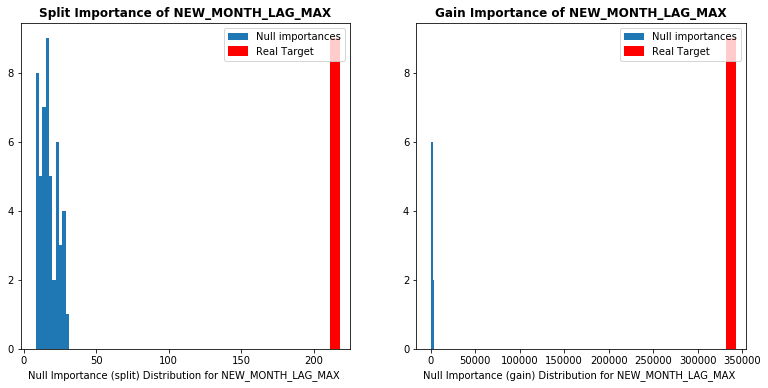

In [32]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='new_month_lag_max')

In [33]:
actual_imp_df.loc[actual_imp_df['feature'] == 'new_authorized_flag_mean']

,feature,importance_gain,importance_split,trn_score
45,new_authorized_flag_mean,0.0,0,3.50521


In [34]:
actual_imp_df.drop([45], axis = 0, inplace = True)

## 3.2 Feature selection

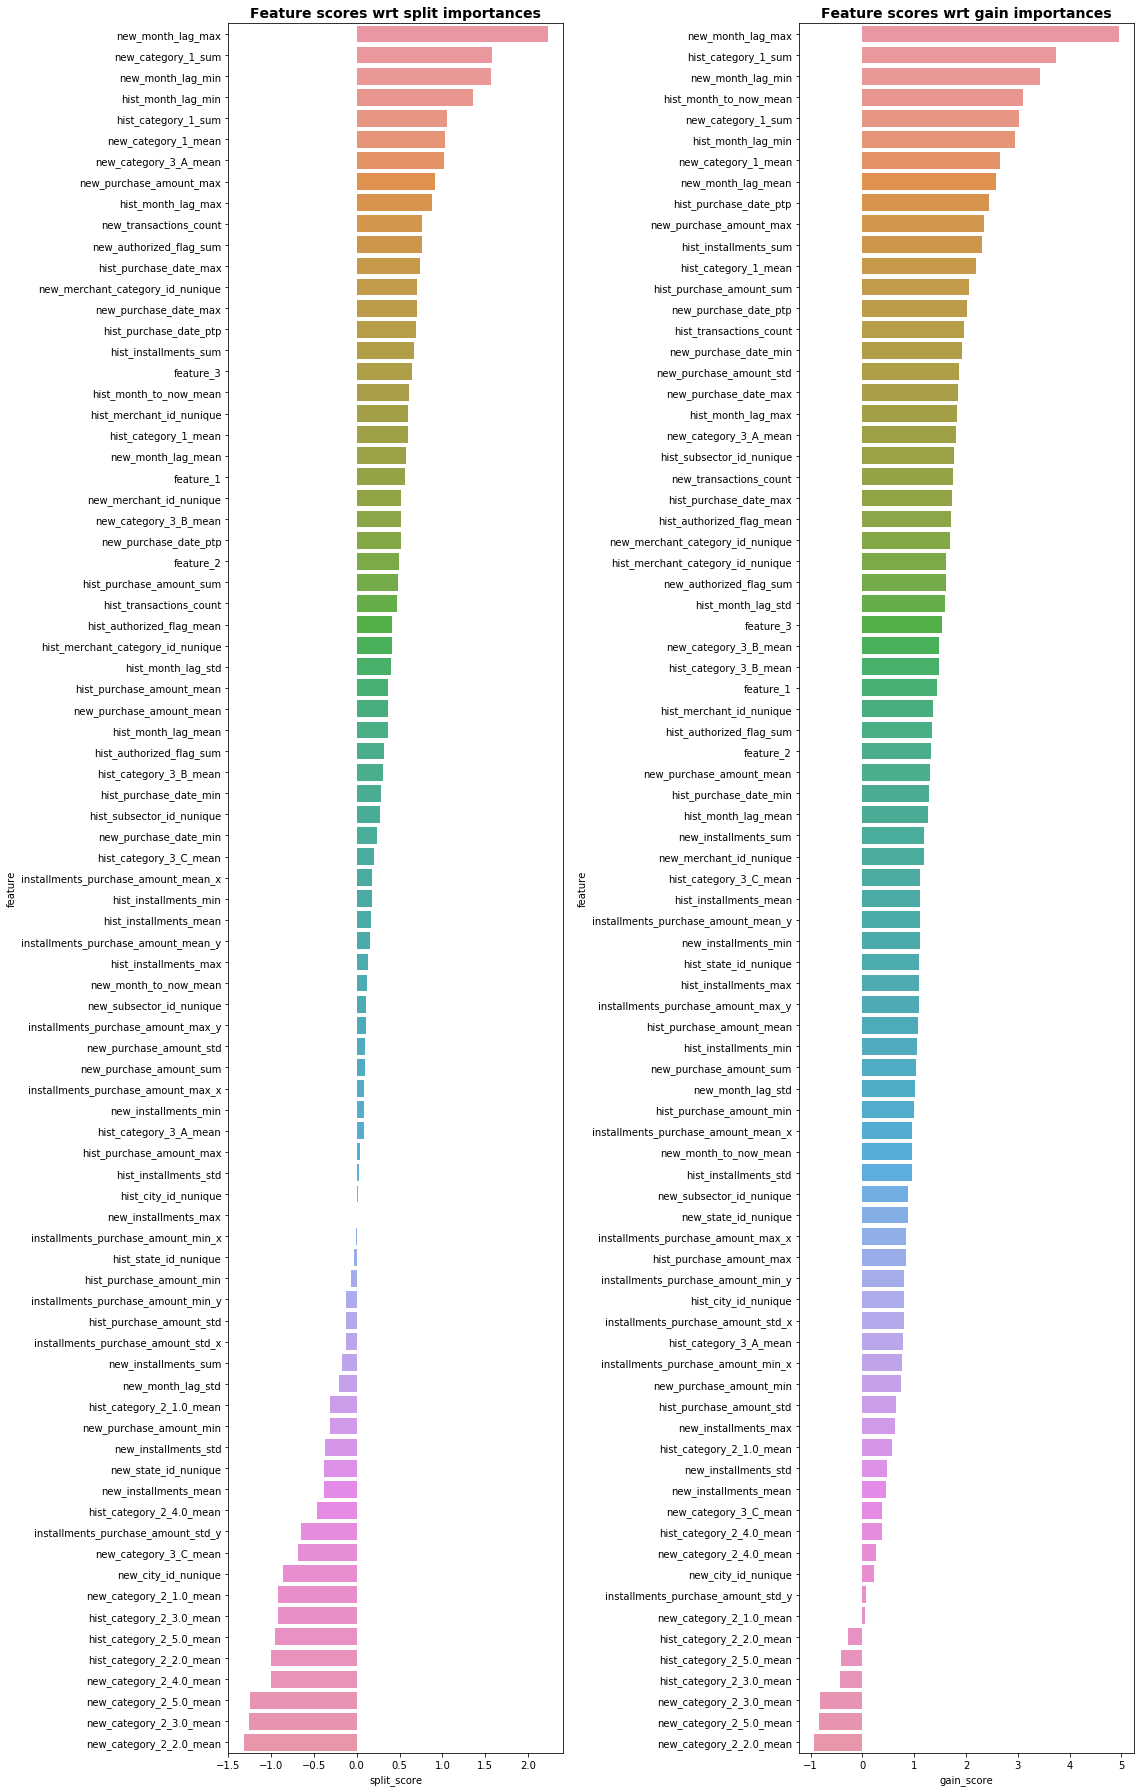

In [35]:
feature_scores = []
max_features = 300
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  
    feature_scores.append((_f, split_score, gain_score))
    
scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 25))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:max_features], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:max_features], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [36]:
final_features = list(scores_df[scores_df['split_score'] > 0]['feature'])
final_features

['feature_1',
 'feature_2',
 'feature_3',
 'hist_transactions_count',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_category_3_A_mean',
 'hist_category_3_B_mean',
 'hist_category_3_C_mean',
 'hist_merchant_id_nunique',
 'hist_merchant_category_id_nunique',
 'hist_city_id_nunique',
 'hist_subsector_id_nunique',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_max',
 'hist_installments_sum',
 'hist_installments_mean',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_std',
 'hist_purchase_date_ptp',
 'hist_purchase_date_min',
 'hist_purchase_date_max',
 'hist_month_lag_mean',
 'hist_month_lag_max',
 'hist_month_lag_min',
 'hist_month_lag_std',
 'hist_month_to_now_mean',
 'installments_purchase_amount_mean_x',
 'installments_purchase_amount_max_x',
 'new_transactions_count',
 'new_authorized_flag_sum',
 'new_category_1_sum',
 'new_category_1_mean',
 'new_category_3_A

# 4. Training the LGB model

In [37]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [38]:
final_train = train[final_features]
final_test = test[final_features]

In [39]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][final_features],
                           label=target.iloc[trn_idx],
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][final_features],
                           label=target.iloc[val_idx],
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][final_features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test[final_features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72086	valid_1's rmse: 3.77812
[200]	training's rmse: 3.65596	valid_1's rmse: 3.72929
[300]	training's rmse: 3.61574	valid_1's rmse: 3.70588
[400]	training's rmse: 3.58725	valid_1's rmse: 3.69303
[500]	training's rmse: 3.5659	valid_1's rmse: 3.68587
[600]	training's rmse: 3.54853	valid_1's rmse: 3.68137
[700]	training's rmse: 3.53406	valid_1's rmse: 3.67861
[800]	training's rmse: 3.52161	valid_1's rmse: 3.67676
[900]	training's rmse: 3.50939	valid_1's rmse: 3.67533
[1000]	training's rmse: 3.49888	valid_1's rmse: 3.67447
[1100]	training's rmse: 3.48817	valid_1's rmse: 3.67394
[1200]	training's rmse: 3.47903	valid_1's rmse: 3.67344
[1300]	training's rmse: 3.46959	valid_1's rmse: 3.67318
[1400]	training's rmse: 3.46021	valid_1's rmse: 3.67259
[1500]	training's rmse: 3.45141	valid_1's rmse: 3.67227
[1600]	training's rmse: 3.44273	valid_1's rmse: 3.67222
[1700]	training's rmse: 3.4349	valid_1's r

In [40]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)